# Colapse all simulation into a unique .feather file

In [1]:
import glob, os
import pandas as pd
import numpy as np
from scipy.stats import ecdf, wasserstein_distance

df_complete_file = 'df_complete_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_complete_file) ):
    print(f'{df_complete_file} already exists. Reading it.')
    df_all = pd.read_feather(df_complete_file)
else:
    print(f'{df_complete_file} does not exists. Generating it.')
    data_files = glob.glob('../output_SA_ex1/SummaryFile_*.feather')
    df_all = pd.concat((pd.read_feather(file) for file in data_files), ignore_index=True)
    df_all.to_feather(df_complete_file)

params_list = ['cycle_tumor_base','necrosis_tumor_base','tumor2motile_base','cycle_motile_base','necrosis_motile_base',
               'cycle_tumor_sat','cycle_tumor_hfm','cycle_tumor_hp',
                   'mechano_tumor_hfm','mechano_tumor_hp',
                   'necrosis_tumor_hfm','necrosis_tumor_hp',
                   'tumor2motile_hfm','tumor2motile_hp',
                   'cycle_motile_sat', 'cycle_motile_hfm', 'cycle_motile_hp',
                   'mechano_motile_hfm', 'mechano_motile_hp',
                   'necrosis_motile_hfm', 'necrosis_motile_hp',
                   'motile2tumor_sat', 'motile2tumor_hfm', 'motile2tumor_hp']
df_all # 233530 rows = 193 samples * 10 repplicates * 121 time points

df_complete_ex1.feather already exists. Reading it.


,time,replicate,sample,runtime,tumor_live,tumor_dead,motile_live,motile_dead,dist_tumor_live,dist_tumor_dead,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0.0,4,107,0.000024,2000,0,0,0,"[77.9878646113564, 257.21390187394763, 225.465...",[],...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
1,60.0,4,107,1.424883,1971,53,59,1,"[77.275806223348, 259.0251499857681, 232.97420...","[330.0727888976101, 329.4770231444414, 179.320...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
2,120.0,4,107,2.637469,1863,96,120,6,"[81.49872598675346, 259.584509925866, 234.3937...","[68.749630939196, 332.58504467623186, 59.12970...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
3,180.0,4,107,3.740179,1799,126,158,11,"[81.75172711972465, 260.21224452866056, 234.87...","[70.02253725444162, 333.81173196946605, 58.836...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
4,240.0,4,107,4.853511,1743,148,198,15,"[82.61854715483837, 260.76848265531856, 237.02...","[71.03552287740165, 251.38219708074263, 334.83...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233525,6960.0,8,185,180.035991,2011,495,239,177,"[292.0375374270333, 358.849235600439, 389.1548...","[333.48678311537867, 120.82893194408948, 317.8...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.92
233526,7020.0,8,185,181.820037,1997,494,254,177,"[291.9200156695263, 358.41506773608637, 389.53...","[334.87528761179783, 121.25870429995692, 317.7...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.92
233527,7080.0,8,185,183.592083,1993,496,261,179,"[292.36275089583216, 359.34127700888195, 390.2...","[334.4524371650632, 121.44998808581252, 315.67...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.92
233528,7140.0,8,185,185.392647,2013,496,248,180,"[293.9236083609693, 360.344020684836, 390.5400...","[335.64544197169243, 121.79449346716736, 312.8...",...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.92


# Define the QoIs: AUC of each mean population, distribution of cell distance from the center at the last time

- Population: store the population of each cell type over time.
    - Summary over time and replicates: Area under curve (AUC) of the average populations.
- Invasion: Distance of cells from the center - provides insights into the spatial distribution and invasion characteristics of the cells.
    - Summary over time and replicates: Pooling the distances from replicates and calculate the Wassertein distance between tumor and motile.


In [2]:
df_qoi_file = 'df_qoi_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
df_summary_file = 'df_summary_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_summary_file) & os.path.exists(df_qoi_file) ):
    print(f'{df_summary_file} and {df_qoi_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
    df_qoi = pd.read_feather(df_qoi_file)
else:
    print(f'{df_summary_file} or {df_qoi_file} does not exists. Generating it.')
    # Calculate the AUC for each sample and replicate
    def calculate_auc_wassertein_dist(group):
        auc_values = {}
        for col in ['tumor_live', 'tumor_dead', 'motile_live', 'motile_dead']: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapz(group[col][mask_notna], group['time'][mask_notna])
        wasserstein_values = {}
        subgroup = group[group['time'] == 7200.0] # select the last time point
        emp_tumor_cdf = ecdf(subgroup['dist_tumor_live'].values[0])
        emp_motile_cdf = ecdf(subgroup['dist_motile_live'].values[0])
        wasserstein_values['Wasserstein_dist'] = wasserstein_distance(emp_tumor_cdf.cdf.quantiles, emp_motile_cdf.cdf.quantiles, emp_tumor_cdf.cdf.probabilities, emp_motile_cdf.cdf.probabilities)
        return pd.Series({**auc_values, **wasserstein_values})

    # Group by 'SampleID' and 'replicate' then calculate AUC and Wassertein distance for each QOI - row dimension of samples x replicates
    df_qoi = df_all.groupby(['sample', 'replicate']).apply(calculate_auc_wassertein_dist).reset_index()
    # Add the parameter values to the QoI dataframe
    df_qoi = df_qoi.merge(df_all[['sample', 'replicate'] + params_list], on=['sample', 'replicate'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Calculate the mean and standard deviation of the QoI for each sample
    df_summary = df_qoi.groupby(['sample']).agg({'AUC_tumor_live': ['mean', 'std'], 'AUC_tumor_dead': ['mean', 'std'], 'AUC_motile_live': ['mean', 'std'], 'AUC_motile_dead': ['mean', 'std'], 'Wasserstein_dist': ['mean', 'std']}).reset_index()
    df_summary.columns = ['_'.join(col) if col[1] else col[0] for col in df_summary.columns]
    # Add the parameter values to the summary dataframe
    df_summary = df_summary.merge(df_qoi[['sample'] + params_list], on=['sample'], how='left').drop_duplicates().reset_index(drop=True)
    
    
    # Save the dataframes to feather files
    df_qoi.to_feather(df_qoi_file)
    df_summary.to_feather(df_summary_file)

print(df_qoi.shape)
print(df_summary.shape)
df_summary

df_summary_ex1.feather and df_qoi_ex1.feather already exists. Reading it.
(1930, 31)
(193, 35)


,sample,AUC_tumor_live_mean,AUC_tumor_live_std,AUC_tumor_dead_mean,AUC_tumor_dead_std,AUC_motile_live_mean,AUC_motile_live_std,AUC_motile_dead_mean,AUC_motile_dead_std,Wasserstein_dist_mean,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0,12585177.0,95209.389716,2594274.0,67928.874273,1607553.0,52032.079432,864186.0,46683.030750,120.744077,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
1,1,12554385.0,128291.607091,2550465.0,53079.094284,1581216.0,64541.866722,874494.0,70150.921305,113.590944,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
2,2,12598353.0,134470.788240,2582190.0,43154.999710,1600212.0,74200.872232,887025.0,60916.558094,117.276896,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
3,3,12546819.0,180264.127352,2544669.0,53057.472706,1579359.0,43926.859778,900648.0,73182.561037,113.731433,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
4,4,12574389.0,62718.770795,2623593.0,109022.033966,1598298.0,44799.199100,862356.0,73005.185843,114.354960,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,188,12547587.0,119876.621115,2570892.0,59567.409210,1620177.0,45175.337187,869181.0,91039.391529,117.352346,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.4
189,189,12667215.0,162696.363358,2565039.0,65301.967888,1580751.0,64992.358089,882894.0,63996.260516,116.137437,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,7.2
190,190,12618909.0,175021.825525,2528511.0,82882.613436,1642353.0,70523.067786,924876.0,43039.551113,120.392069,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,8.8
191,191,12753066.0,130991.489647,2685759.0,76770.231275,1562127.0,56509.571667,799644.0,47308.893033,115.625111,...,0.0072,21.5,4.0,0.25,3.0,3.75,8.0,0.005,6.75,6.4


# Local sensitivity analysis: 
Give $\theta^\star$ as the reference parameter set, we added a multiplicative perturbation $\delta$, which
$$\theta_i = \theta^\star \times (1\pm \delta), \quad \delta = \{0.01, 0.05, 0.1, 0.2\}$$

Absolute sensitivity (A unit increase in $\theta_i$ changes the output by $S_{\theta_i}$ units): 
$$S_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{\theta_i - \theta^\star}$$
Relative sensitivity (Elasticity -  For every $1\%$ change in $\theta_i$, the output changes by $\bar{S}_{\theta_i} \times 1\%$:

$$\bar{S}_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{f(\theta^\star)}\cdot \dfrac{\theta^\star}{\theta_i - \theta^\star}$$

- $S>0:$ As the parameter increases, the output also increases.
- $S<0:$ As the parameter increases, the output decreases.
- $S=0:$ The output is insensitive to changes in the parameter.
- $∣S∣≫1:$ The output is highly sensitive to the parameter; small changes in the parameter will cause large changes in the output.
- $∣S∣≪1:$ The output is relatively insensitive to the parameter; large changes in the parameter will have little effect on the output.

In [3]:
sample_ref = 0 # Sample with reference parameters
print('Sample with reference parameters: ', df_summary.iloc[sample_ref][params_list].values)

# Calculate the sensitivity index
QoIs_list = ['AUC_tumor_live_mean', 'AUC_tumor_dead_mean', 'AUC_motile_live_mean', 'AUC_motile_dead_mean', 'Wasserstein_dist_mean']
# Function to calculate SI using
def calculate_SI_multiple():
    sensitivity_analysis_dic = {}
    # Calculate the delta of parameters
    non_zero_values = []; non_zero_params= []
    relative_change_params = (df_summary[params_list] - df_summary.iloc[sample_ref][params_list].values) / np.where(df_summary.iloc[sample_ref][params_list].values != 0, df_summary.iloc[sample_ref][params_list].values, 1)
    for index, row in relative_change_params.iterrows():
        # First index is the reference sample - include the value 1 and skip it
        if index == sample_ref: non_zero_values.append(1); non_zero_params.append(params_list[0]); continue
        # Get the non-zero values in the row
        non_zero_row_values = row[row != 0.0]
        # Check if there is exactly one non-zero value
        if len(non_zero_row_values) == 1: non_zero_values.append(non_zero_row_values.iloc[0])
        else: raise ValueError(f"Row {index} contains more than one non-zero value or all values are zero. Non zero: {non_zero_row_values} - Row: {row.values}")
        # Parameter name with non-zero value
        non_zero_params.append(non_zero_row_values.index[0])
    relative_change_params_1d = pd.DataFrame(non_zero_values, columns=['NonZeroValues'])
    sensitivity_analysis_dic['SA_parameter'] = np.array(non_zero_params)
    sensitivity_analysis_dic['SA_delta'] = relative_change_params_1d.to_numpy()[:,0].round(2)
    # Calculate the delta of QoIs
    absolute_change_qois = df_summary[QoIs_list] - df_summary.iloc[sample_ref][QoIs_list].values
    relative_change_qois = absolute_change_qois / np.where(df_summary.iloc[sample_ref][QoIs_list].values != 0, df_summary.iloc[sample_ref][QoIs_list].values, 1)
    absolute_change_params = sensitivity_analysis_dic['SA_delta'] * df_summary.iloc[sample_ref][ sensitivity_analysis_dic['SA_parameter'] ].to_numpy()
    for id_qoi, qoi in enumerate(QoIs_list): 
        sensitivity_analysis_dic[f'SI_{qoi}'] = relative_change_qois.to_numpy()[:,id_qoi]/sensitivity_analysis_dic['SA_delta']
        parameter_name = sensitivity_analysis_dic['SA_parameter']
        sensitivity_analysis_dic[f'Abs_SI_{qoi}'] = absolute_change_qois.to_numpy()[:,id_qoi]/absolute_change_params
    
    # Change the delta of reference value to 0 and label it as reference
    sensitivity_analysis_dic['SA_delta'][0] = 0
    sensitivity_analysis_dic['SA_parameter'][0] = 'Reference'
    return pd.DataFrame(sensitivity_analysis_dic)

# Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
df_SA = calculate_SI_multiple() # calculate the AUC for each QOI
df_SA = pd.concat([df_summary['sample'], df_SA], axis=1)

# Print the sensitivity index
for qoi in QoIs_list:
    sample_lowest_qoi = df_summary.iloc[df_summary[qoi].idxmin()]['sample']; sample_highest_qoi = df_summary.iloc[df_summary[qoi].idxmax()]['sample']
    sample_lowest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmin()]['sample']; sample_highest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmax()]['sample']
    print(f"QoI: {qoi}")
    print(f"\t lowest and highest QoI: {sample_lowest_qoi} ({df_SA.iloc[int(sample_lowest_qoi)]['SA_parameter']}) and {sample_highest_qoi} ({df_SA.iloc[int(sample_highest_qoi)]['SA_parameter']})")
    print(f"\t lowest and highest SI: {sample_lowest_si} ({df_SA.iloc[int(sample_lowest_si)]['SA_parameter']}) and {sample_highest_si} ({df_SA.iloc[int(sample_highest_si)]['SA_parameter']})\n")
df_SA

Sample with reference parameters:  [7.20e-04 2.80e-03 1.00e-03 7.20e-04 2.80e-03 7.20e-03 2.15e+01 4.00e+00
 2.50e-01 3.00e+00 3.75e+00 8.00e+00 6.75e+00 8.00e+00 7.20e-03 2.15e+01
 4.00e+00 2.50e-01 3.00e+00 3.75e+00 8.00e+00 5.00e-03 6.75e+00 8.00e+00]
QoI: AUC_tumor_live_mean
	 lowest and highest QoI: 184.0 (motile2tumor_hfm) and 55.0 (cycle_tumor_hfm)
	 lowest and highest SI: 169 (motile2tumor_sat) and 186 (motile2tumor_hp)

QoI: AUC_tumor_dead_mean
	 lowest and highest QoI: 87.0 (necrosis_tumor_hfm) and 88.0 (necrosis_tumor_hfm)
	 lowest and highest SI: 114 (cycle_motile_sat) and 81 (necrosis_tumor_hfm)

QoI: AUC_motile_live_mean
	 lowest and highest QoI: 103.0 (tumor2motile_hfm) and 184.0 (motile2tumor_hfm)
	 lowest and highest SI: 73 (mechano_tumor_hp) and 18 (tumor2motile_base)

QoI: AUC_motile_dead_mean
	 lowest and highest QoI: 159.0 (necrosis_motile_hfm) and 160.0 (necrosis_motile_hfm)
	 lowest and highest SI: 81 (necrosis_tumor_hfm) and 154 (necrosis_motile_hfm)

QoI: Wasse

,sample,SA_parameter,SA_delta,SI_AUC_tumor_live_mean,Abs_SI_AUC_tumor_live_mean,SI_AUC_tumor_dead_mean,Abs_SI_AUC_tumor_dead_mean,SI_AUC_motile_live_mean,Abs_SI_AUC_motile_live_mean,SI_AUC_motile_dead_mean,Abs_SI_AUC_motile_dead_mean,SI_Wasserstein_dist_mean,Abs_SI_Wasserstein_dist_mean
0,0,Reference,0.00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
1,1,cycle_tumor_base,-0.01,0.244669,4.276667e+09,1.688681,6.084583e+09,1.638329,3.657917e+09,-1.192799,-1.431667e+09,5.924210,993490.613109
2,2,cycle_tumor_base,0.01,0.104695,1.830000e+09,-0.465795,-1.678333e+09,-0.456657,-1.019583e+09,2.642834,3.172083e+09,-2.871512,-481552.812918
3,3,cycle_tumor_base,-0.05,0.060957,1.065500e+09,0.382419,1.377917e+09,0.350769,7.831667e+08,-0.843846,-1.012833e+09,1.161571,194795.655917
4,4,cycle_tumor_base,0.05,-0.017144,-2.996667e+08,0.226029,8.144167e+08,-0.115144,-2.570833e+08,-0.042352,-5.083333e+07,-1.058291,-177475.464003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,188,motile2tumor_hp,0.05,-0.059737,-9.397500e+04,-0.180259,-5.845500e+04,0.157059,3.156000e+04,0.115600,1.248750e+04,-0.561805,-8.479327
189,189,motile2tumor_hp,-0.10,-0.065186,-1.025475e+05,0.112690,3.654375e+04,0.166725,3.350250e+04,-0.216481,-2.338500e+04,0.381521,5.758300
190,190,motile2tumor_hp,0.10,0.026803,4.216500e+04,-0.253493,-8.220375e+04,0.216478,4.350000e+04,0.702279,7.586250e+04,-0.029153,-0.440010
191,191,motile2tumor_hp,-0.20,-0.066701,-1.049306e+05,-0.176321,-5.717812e+04,0.141289,2.839125e+04,0.373427,4.033875e+04,0.211976,3.199354


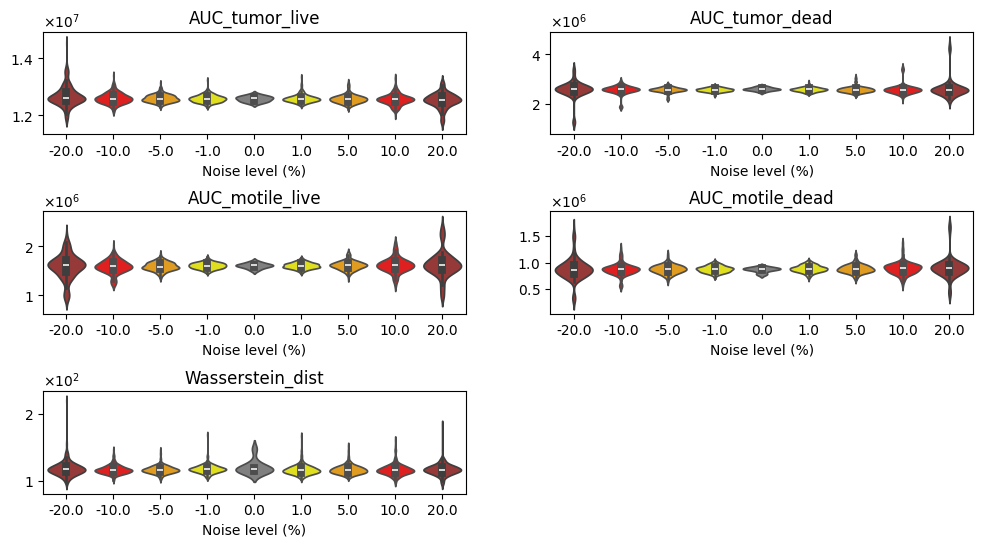

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.75)
for qoi, ax in zip(QoIs_list, axes.flatten()):
    # Plot a box plot for each QoI (x axis: SA_delta, y axis: QoI value)
    # ax.boxplot([df_all[df_summary['sample'] == sample][qoi].values for sample in [sample_ref, *samples_deltap1, *samples_deltam1, *samples_deltap5, *samples_deltam5, *samples_deltap10, *samples_deltam10, *samples_deltap20, *samples_deltam20]], showfliers=False)
    for delta, color in zip([-0.2, -0.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.2], 
                            ['brown', 'red', 'orange', 'yellow', 'gray', 'yellow', 'orange', 'red', 'brown']):
        samples = df_SA[df_SA['SA_delta'] == delta]['sample'].values
        values = df_qoi[df_qoi['sample'].isin(samples)][qoi[:-5]].values
        sns.violinplot(x=[delta*100]*len(values), y=values, ax=ax, color=color)
    
    ax.set_title(qoi[:-5])
    ax.set_xlabel('Noise level (%)')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
axes[2, 1].remove()
# plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))


plt.show()

/var/folders/z0/qjtn97gj62z2_f7wmwlwkvmc0000gn/T/ipykernel_92416/1950461036.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SA["SA_delta"] = df_SA["SA_delta"] * 100


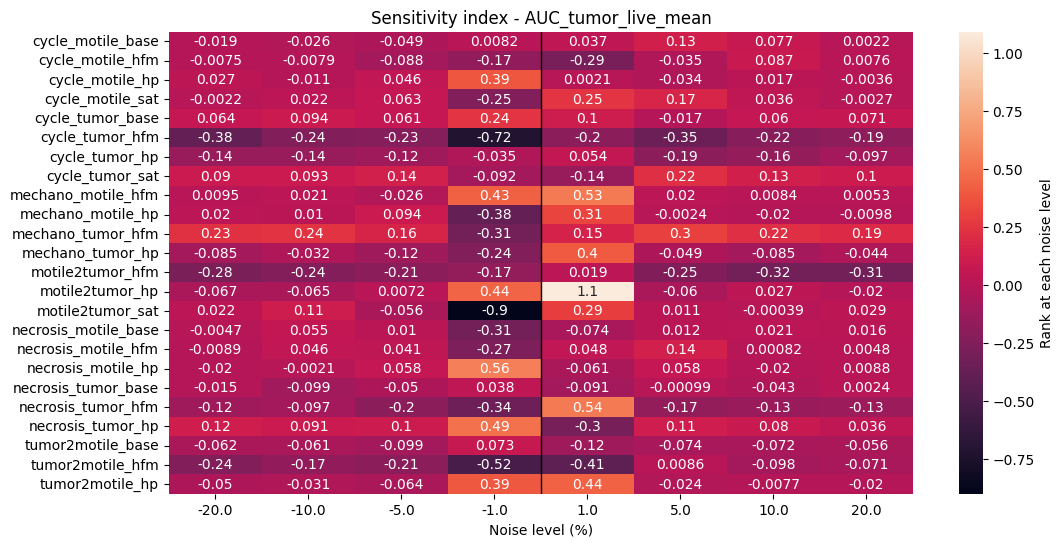

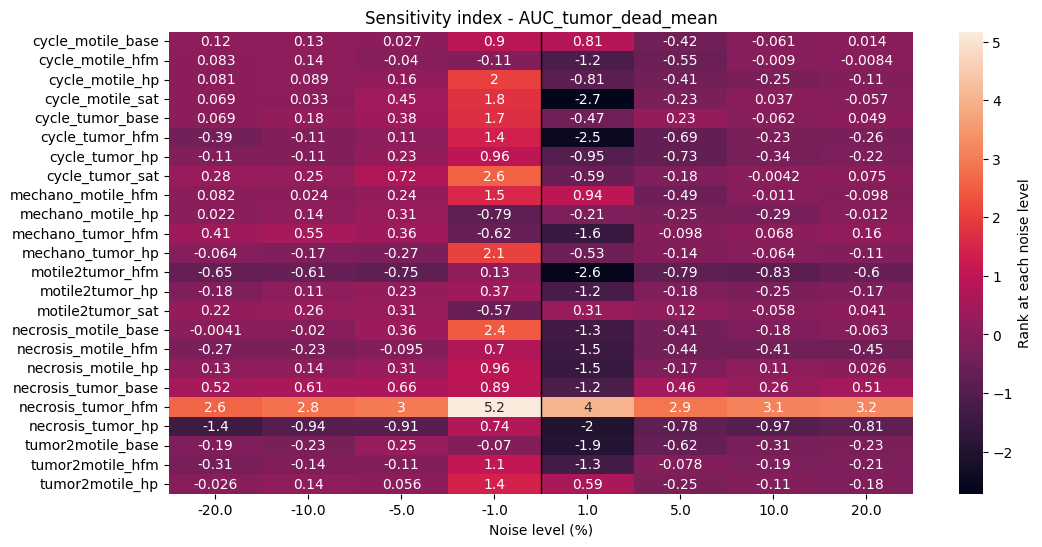

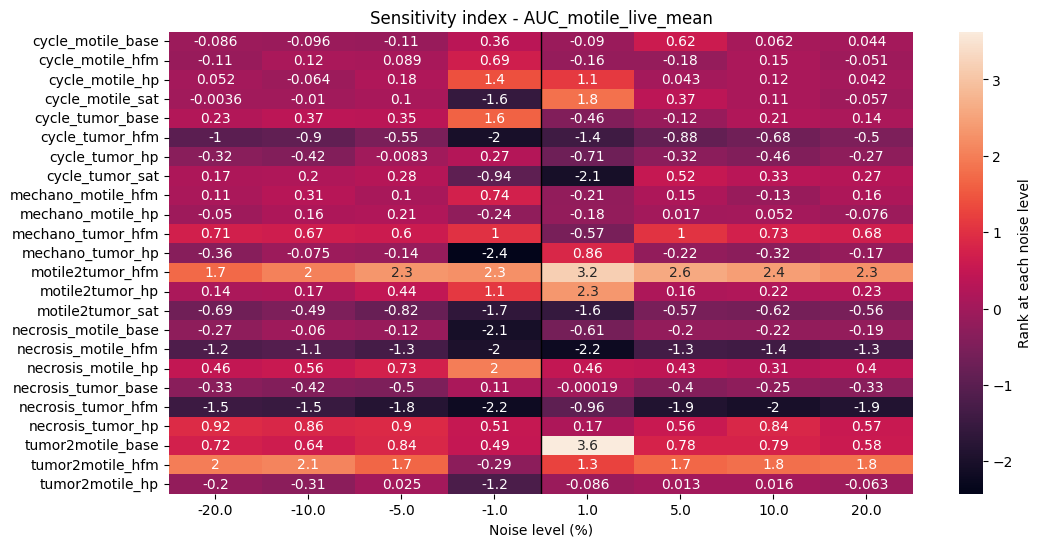

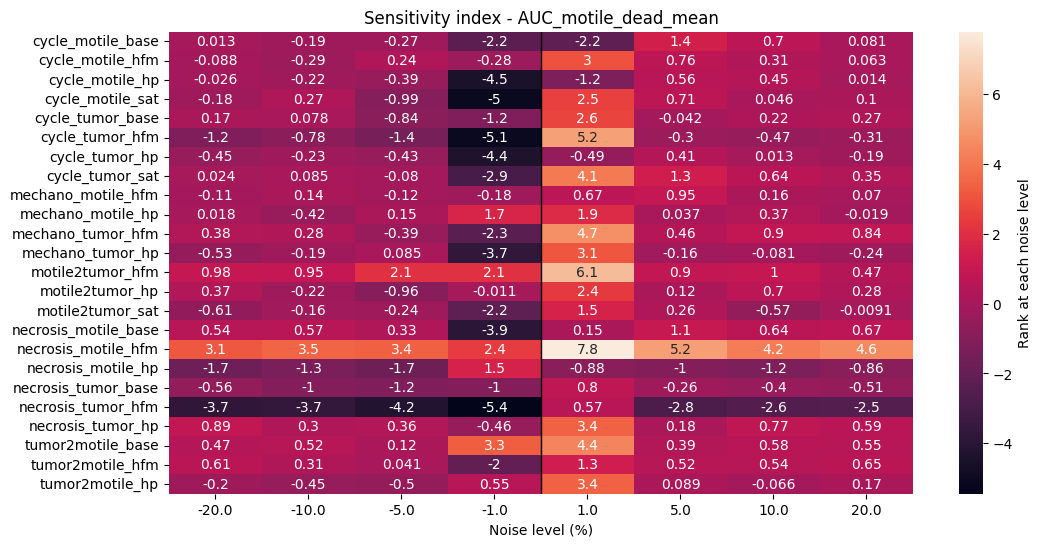

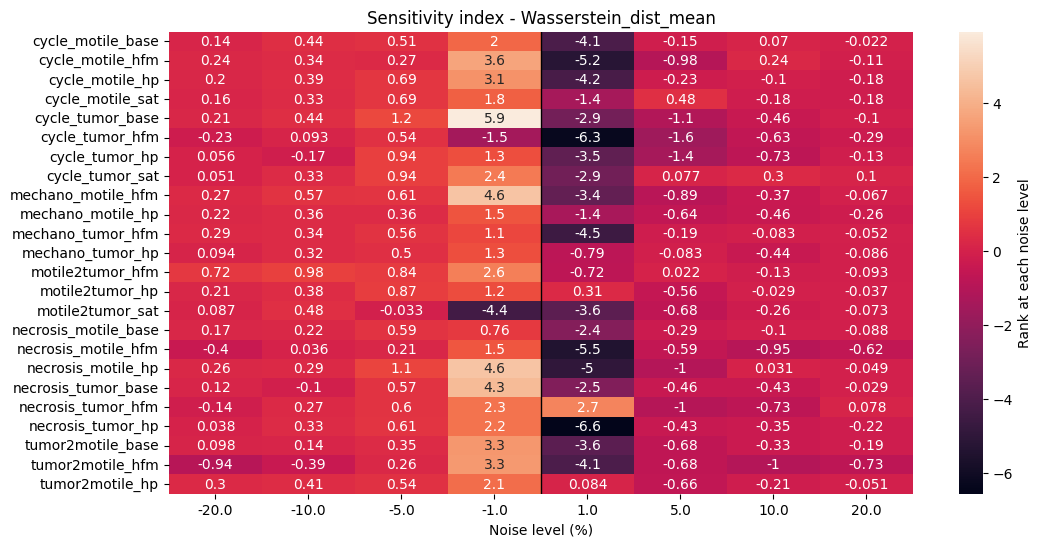

In [5]:
# Drop the reference sample
df_SA = df_SA[df_SA['sample'] != sample_ref]
# Convert the noise level to percentage
df_SA["SA_delta"] = df_SA["SA_delta"] * 100
plot = 'SI' # plot_options =  ["SI", "Abs_SI", 'Rank']
# Plot the parameter rank according to the relatice sensitivity index as heatmap with the parameters vs delta and color as the rank
for qoi in QoIs_list:
    fig, ax = plt.subplots(figsize=(12, 6))
    if plot == 'SI':
        # pivot the dataframe to have the parameter as index, delta as columns and sensitivity index as values
        df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi)
    if plot == 'Abs_SI':
        # pivot the dataframe to have the parameter as index, delta as columns and absolute sensitivity index as values
        df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
    if plot == 'Rank':
        df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
        # rank of each parameter for each noise level ( 1 - highest sensitivity, 2 - second highest sensitivity, etc)
        df_SA_pivot_plot = df_SA_pivot.rank(axis=0, method='min', ascending=False)
    # print(df_SA_pivot.head(),'\n')
    # print(df_SA_pivot_rank.head(),'\n')
    # 
    sns.heatmap(df_SA_pivot_plot, cmap='rocket', annot=True,ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Rank at each noise level')
    # draw a line to separate the positive and negative values
    ax.axvline(4, color='black', lw=1)
    ax.set(title = f'Sensitivity index - {qoi}', xlabel='Noise level (%)', ylabel=None)
plt.show()

# Calculate the Rank Sensitivity Index (RSI) in different noise
$$ RSI_i = \frac{N-Rank_i}{N-1}$$

where:
- $Rank_i$ is the rank of parameter (1 = most sensitive, N = least sensitive).
- $N$ is the total number of parameters.

The RSI scales the rank to a value between 0 and 1:
- RSI close to 1: Indicates high sensitivity (high importance).
- RSI close to 0: Indicates low sensitivity (low importance).

Explanation:
- Rank DataFrame: Contains the ranks of each parameter at each noise level.
- RSI DataFrame: Converts the ranks to RSI values using the formula.
- Mean RSI: Averages the RSI values across all noise levels to get a summary measure for each parameter.
Interpretation:
- The parameter with the highest RSI is the most sensitive across all noise levels.
- The RSI values provide a more stable measure of sensitivity than raw rankings, especially when ranks fluctuate across noise levels.

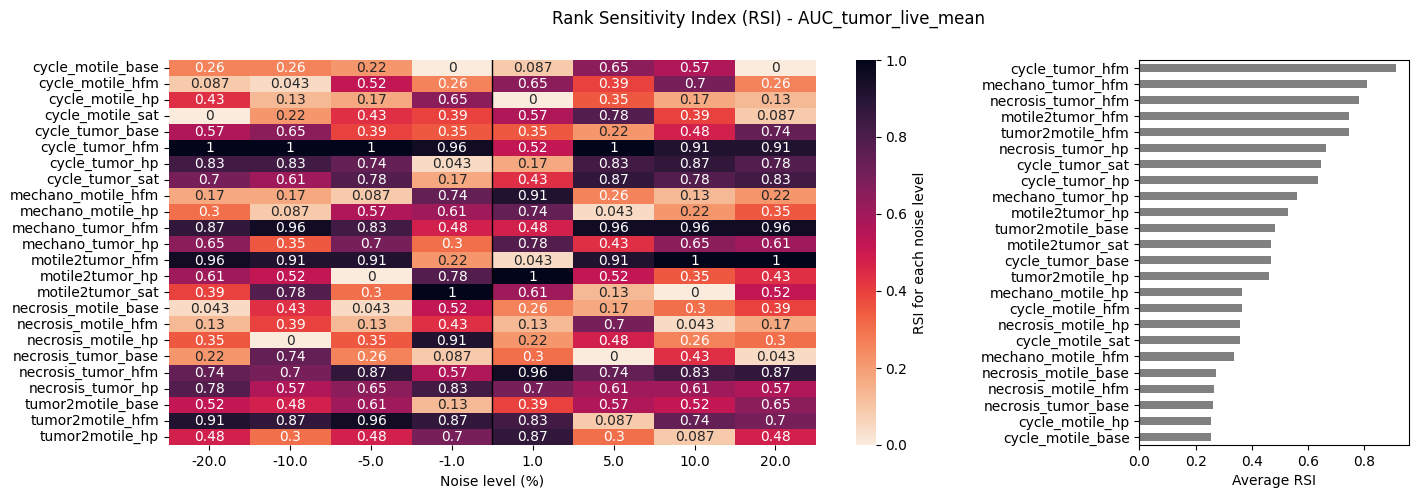

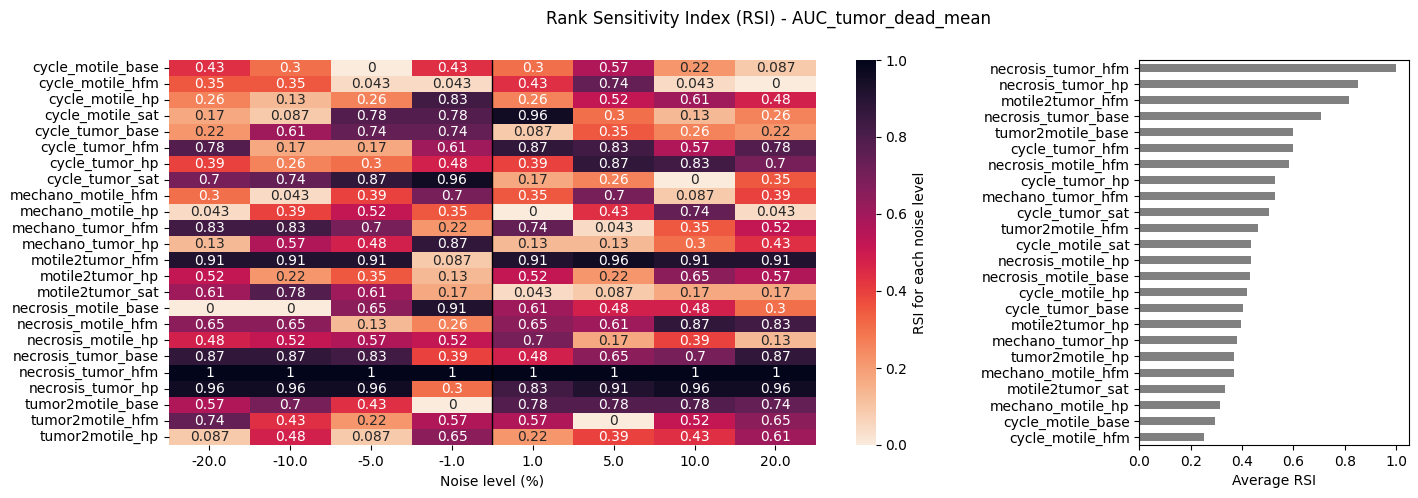

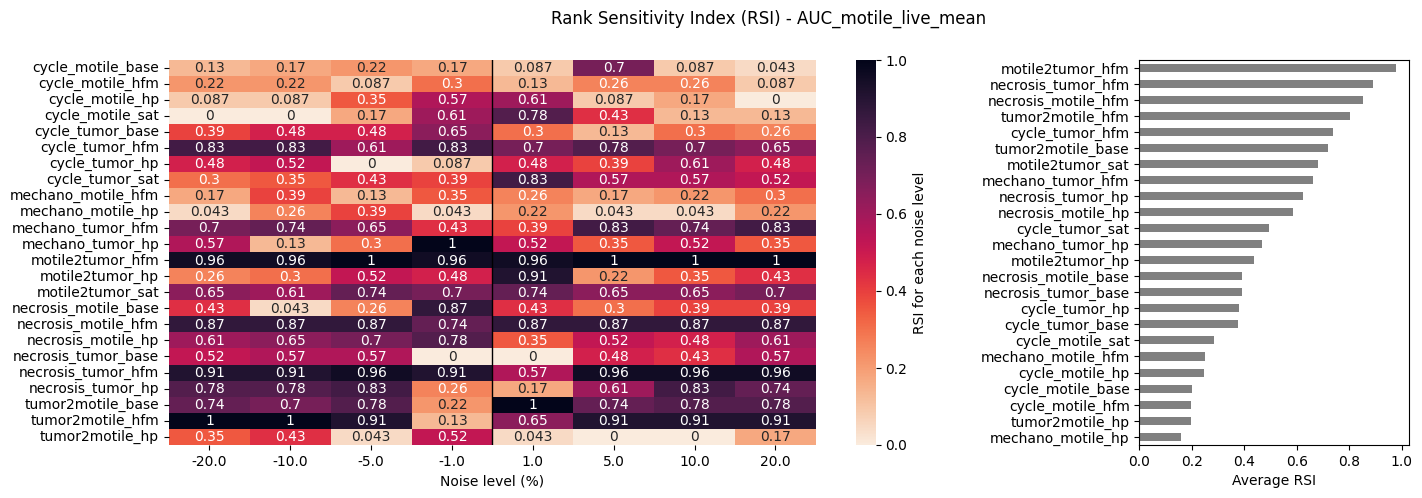

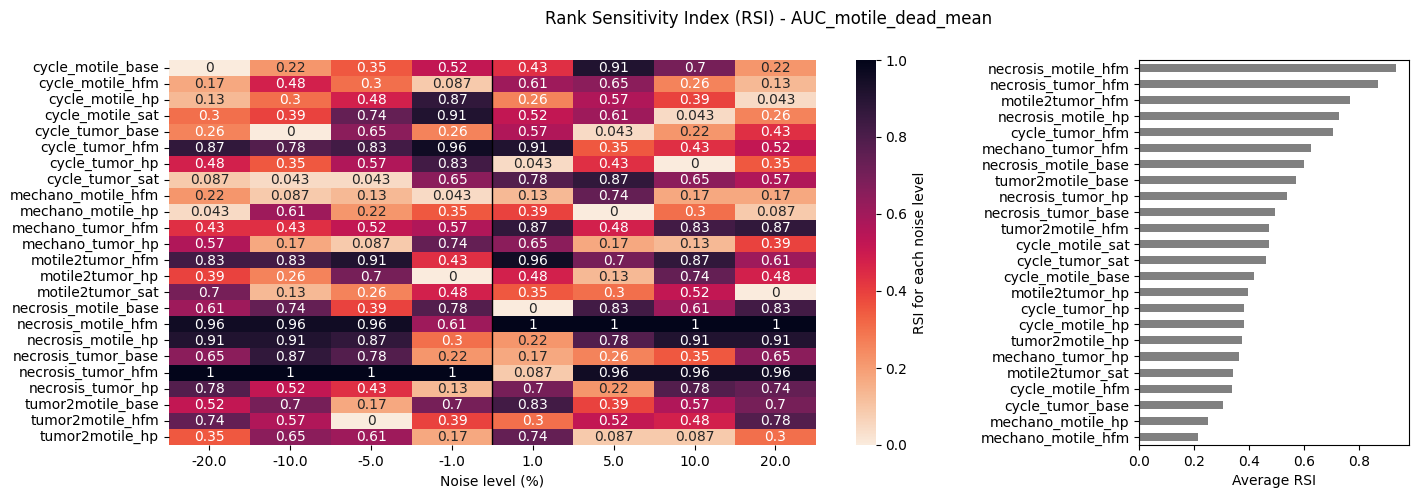

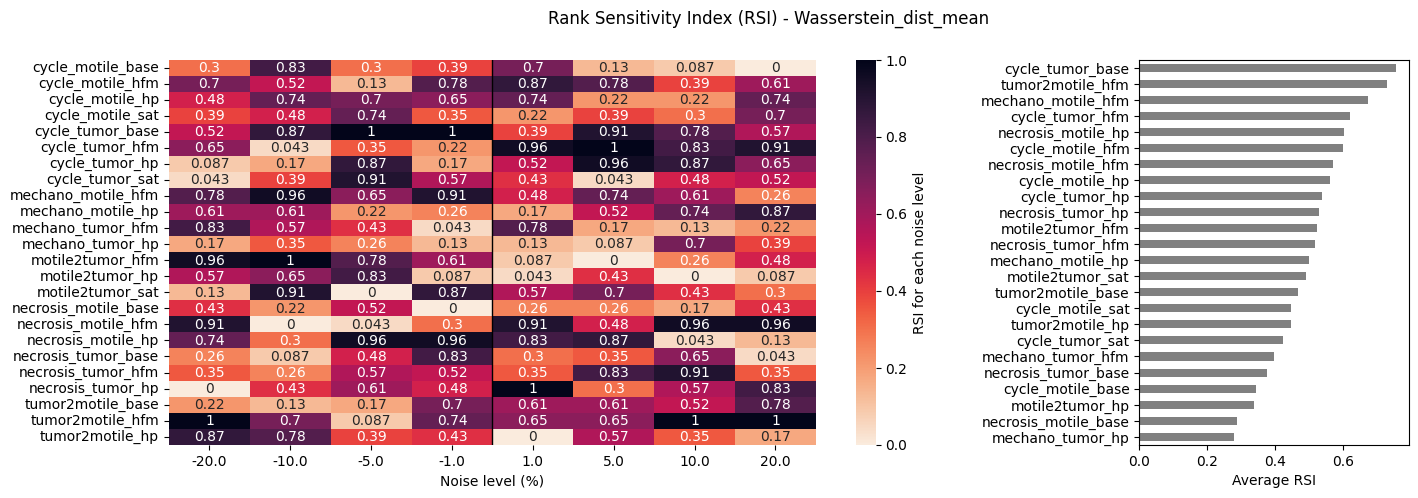

In [6]:
for qoi in QoIs_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle(f'Rank Sensitivity Index (RSI) - {qoi}')
    # Round the values to 2 decimal places
    # df_SA['SA_delta'] = df_SA['SA_delta'].round(2)
    df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
    # df of the rank of each parameter for each noise level
    df_SA_pivot_rank = df_SA_pivot.rank(axis=0, method='min', ascending=False)
    # convert the rank to rank sensitivity index
    df_SA_pivot_RSI = (df_SA_pivot_rank.shape[0] - df_SA_pivot_rank) / (df_SA_pivot_rank.shape[0] - 1)
    sns.heatmap(df_SA_pivot_RSI, cmap='rocket_r', annot=True,ax=ax1)
    cbar = ax1.collections[0].colorbar
    cbar.set_label('RSI for each noise level')
    ax1.set(xlabel='Noise level (%)', ylabel=None)
    # draw a line to separate the positive and negative values
    ax1.axvline(4, color='black', lw=1)
    # Average the RSI across all noise levels
    df_rsi_mean = df_SA_pivot_RSI.mean(axis=1)
    df_rsi_mean = df_rsi_mean.sort_values(ascending=True)
    df_rsi_mean.plot(kind='barh', ax=ax2, color='gray')
    ax2.set(xlabel='Average RSI', ylabel=None)